In [45]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge




In [46]:
df_TB = pd.read_pickle("data/dades_TBert.pkl")
df_TB = df_TB.iloc[:, 2:]

In [47]:
df_TB['Investment'] = np.log1p(df_TB['Investment'])
df_TB['Inv_previa'] = np.log1p(df_TB['Inv_previa'])
print(df_TB[['Investment', 'Inv_previa']].head())

   Investment  Inv_previa
0    5.252273    6.369901
1    4.564348    6.192362
2    5.492650    5.509793
3    4.890349    4.745801
4    3.988984    4.128746


In [48]:
x = df_TB.drop("Investment", axis=1)
x.columns = x.columns.astype(str)   #No se perquè, però si no ho faig em dona error
y = df_TB["Investment"]

In [49]:
print(x.shape)
print(y.shape)

(623, 885)
(623,)


Model de regressió normal i corrent

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

results = []
m = []
n = []
test_mse = []

for r in range(1,41):
    print(f"{round((r-1)/40*100,1)}%", end='\r', flush=True)
    train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
    reg = LinearRegression().fit(train_X, train_y)
    m.append(reg.score(train_X, train_y))
    n.append(reg.score(test_X, test_y))
    y_pred = reg.predict(test_X)
    y_pred_original = np.expm1(y_pred)  # exp(x) - 1
    y_original = np.expm1(test_y)
    test_mse.append(mean_squared_error(y_original, y_pred_original))
results.append([round(float(np.mean(m)), 3), round(float(np.mean(n)), 3) , round(np.mean(test_mse), 3)])

df_results_reg = pd.DataFrame(results, columns=['train_score_mean', 'val_score_mean', 'val_mse_mean'])
print(df_results_reg)
df_results_reg.to_pickle(path="data/reg_TB_log.pkl")

   train_score_mean  val_score_mean  val_mse_mean
0             0.848            0.19         472.6


In [85]:
df_results_reg = pd.read_pickle("data/reg_TB_log.pkl")
reg = LinearRegression().fit(x, y)
y_pred = reg.predict(x)
y_pred_original = np.expm1(y_pred)
y_original = np.expm1(y)
mse_real = mean_squared_error(y_original, y_pred_original)
definitiu = pd.DataFrame([[reg.score(x, y), mse_real]], columns=['R² (score)', 'MSE'])
print(definitiu)
definitiu.to_pickle(path="data/reg_TB_log_opt.pkl")
df_results_reg.to_pickle(path="data/reg_TB_log_rem_opt.pkl")
print(df_results_reg)

   R² (score)         MSE
0    0.826021  269.428922
   train_score_mean  val_score_mean  val_mse_mean
0             0.848            0.19         472.6


Lasso

In [77]:
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge

results = []
c = 0
for i in np.logspace(-5, -1, num=40):
    m = []
    n = []
    test_mse = []
    
    for r in range(1,41):
        print(f"{round((c+(r-1)/40)/40*100,1)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        lasso_reg = linear_model.Lasso(alpha=i, max_iter=100, tol=0.1)
        lasso_reg.fit(train_X, train_y)
        m.append(lasso_reg.score(train_X, train_y))
        n.append(lasso_reg.score(test_X, test_y))
        y_pred = lasso_reg.predict(test_X)
        y_pred_original = np.expm1(y_pred)  # exp(x) - 1
        y_original = np.expm1(test_y)
        test_mse.append(mean_squared_error(y_original, y_pred_original))
    results.append([round(float(i),7), round(float(np.mean(m)),3), round(float(np.mean(n)),3), round(np.mean(test_mse),3)])
    c = c+1

df_results_lasso = pd.DataFrame(results, columns=['alpha', 'train_score_mean', 'val_score_mean', 'val_mse_mean'])
print(df_results_lasso.loc[df_results_lasso['val_score_mean'].idxmax()])
print(df_results_lasso.loc[df_results_lasso['val_mse_mean'].idxmin()])

df_results_lasso.to_pickle(path="data/lasso_TB_log.pkl")

alpha                 0.015118
train_score_mean      0.560000
val_score_mean        0.537000
val_mse_mean        416.369000
Name: 31, dtype: float64
alpha                 0.003665
train_score_mean      0.688000
val_score_mean        0.481000
val_mse_mean        379.324000
Name: 25, dtype: float64


In [78]:
df_results_lasso = pd.read_pickle("data/lasso_TB_log.pkl")

alpha = float(df_results_lasso.loc[df_results_lasso['val_mse_mean'].idxmin(),"alpha"])
lasso_reg = linear_model.Lasso(alpha=alpha, max_iter=1000, tol=0.01)
lasso_reg.fit(x, y)
y_pred = lasso_reg.predict(x)
y_pred_original = np.expm1(y_pred)  # exp(x) - 1
y_original = np.expm1(y)
mse_real = mean_squared_error(y_original, y_pred_original)
definitiu = pd.DataFrame([[lasso_reg.score(x, y), mse_real]], columns=['R² (score)', 'MSE'])
print(definitiu)
best_row = df_results_lasso[df_results_lasso['alpha'] == alpha]
print(best_row)
definitiu.to_pickle(path="data/lasso_TB_log_opt.pkl")
best_row.to_pickle(path="data/lasso_TB_log_rem_opt.pkl")

   R² (score)         MSE
0    0.660114  291.879066
       alpha  train_score_mean  val_score_mean  val_mse_mean
25  0.003665             0.688           0.481       379.324


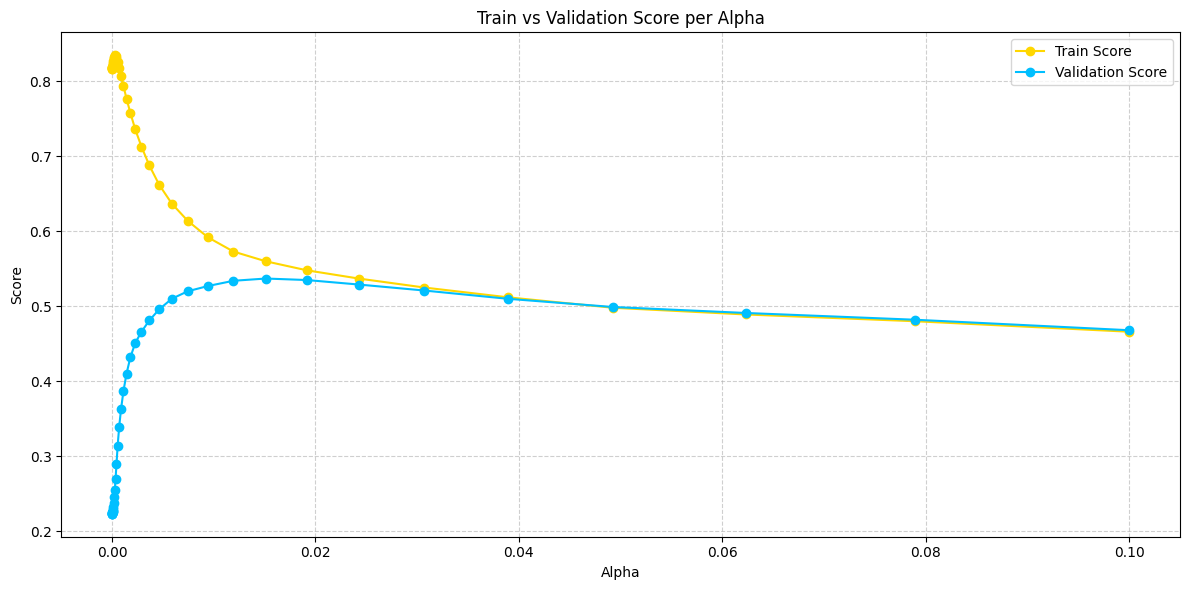

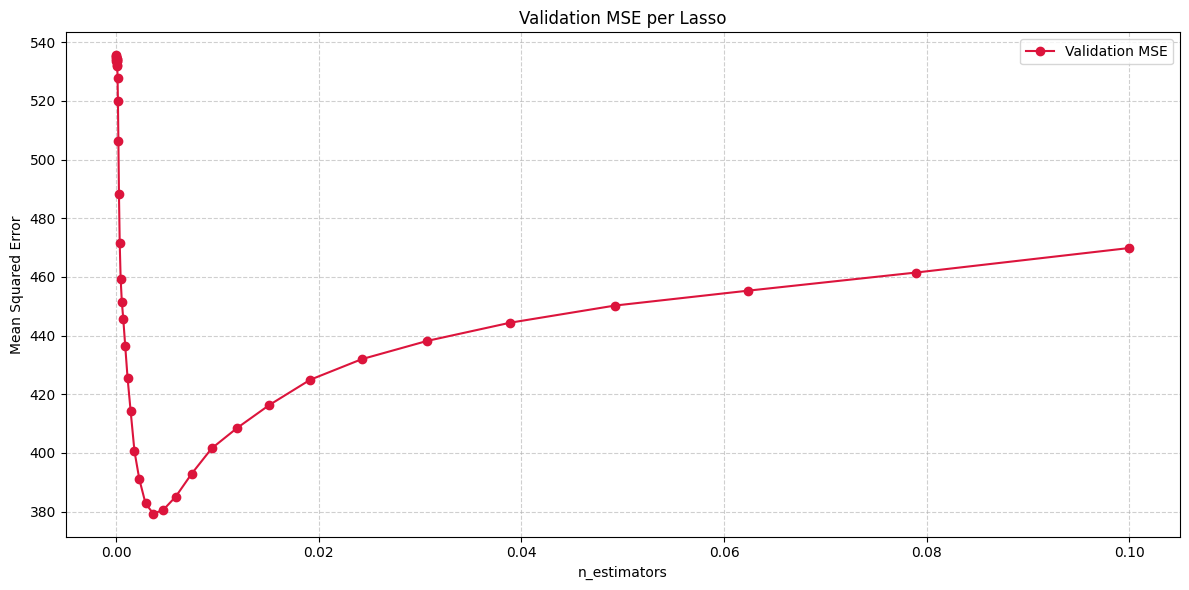

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Dades
alphas = df_results_lasso['alpha']
train_scores = df_results_lasso['train_score_mean']
val_scores = df_results_lasso['val_score_mean']
val_mse = df_results_lasso['val_mse_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(alphas, train_scores, marker='o', color='gold', label='Train Score')
plt.plot(alphas, val_scores, marker='o', color='deepskyblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Train vs Validation Score per Alpha')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.ylim(0.05, 0.5)

# Gràfic 2: MSE en test
plt.figure(figsize=(12, 6))
plt.plot(alphas, val_mse, marker='o', color='crimson', label='Validation MSE')
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE per Lasso')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Ridge

In [80]:
results = []
c=0
for i in np.logspace(-2, 3, num=30):
    m = []
    n = []
    c = c+1
    test_mse = []
    
    print(f"{round((c-1)/30*100,2)}%", end='\r', flush=True)
    for r in range(1,41):
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        ridge_reg = linear_model.Ridge(alpha=i, max_iter=100, tol=0.1)
        ridge_reg.fit(train_X, train_y)
        m.append(ridge_reg.score(train_X, train_y))
        n.append(ridge_reg.score(test_X, test_y))
        y_pred = ridge_reg.predict(test_X)
        y_pred_original = np.expm1(y_pred)  # exp(x) - 1
        y_original = np.expm1(test_y)
        test_mse.append(mean_squared_error(y_original, y_pred_original))
    results.append([round(float(i),7), round(float(np.mean(m)),3), round(float(np.mean(n)),3), round(np.mean(test_mse),3)])

df_results_ridge = pd.DataFrame(results, columns=['alpha', 'train_score_mean', 'val_score_mean', 'val_mse_mean'])
print(df_results_ridge.loc[df_results_ridge['val_score_mean'].idxmax()])
print(df_results_ridge.loc[df_results_ridge['val_mse_mean'].idxmin()])

df_results_ridge.to_pickle(path="data/ridge_TB_log.pkl")

alpha                62.101694
train_score_mean      0.649000
val_score_mean        0.508000
val_mse_mean        404.967000
Name: 22, dtype: float64
alpha                28.072162
train_score_mean      0.697000
val_score_mean        0.491000
val_mse_mean        389.445000
Name: 20, dtype: float64


In [81]:
df_results_ridge = pd.read_pickle("data/ridge_TB_log.pkl")

alpha = float(df_results_ridge.loc[df_results_ridge['val_mse_mean'].idxmin(),"alpha"])
ridge_reg = linear_model.Ridge(alpha=alpha, max_iter=1000, tol=0.01)
ridge_reg.fit(x, y)
y_pred = ridge_reg.predict(x)
y_pred_original = np.expm1(y_pred)  # exp(x) - 1
y_original = np.expm1(y)
mse_real = mean_squared_error(y_original, y_pred_original)
definitiu = pd.DataFrame([[ridge_reg.score(x, y), mse_real]], columns=['R² (score)', 'MSE'])
print(definitiu)
best_row = df_results_ridge[df_results_ridge['alpha'] == alpha]
print(best_row)
definitiu.to_pickle(path="data/ridge_TB_log_opt.pkl")
best_row.to_pickle(path="data/ridge_TB_log_rem_opt.pkl")

   R² (score)         MSE
0    0.686488  292.236293
        alpha  train_score_mean  val_score_mean  val_mse_mean
20  28.072162             0.697           0.491       389.445


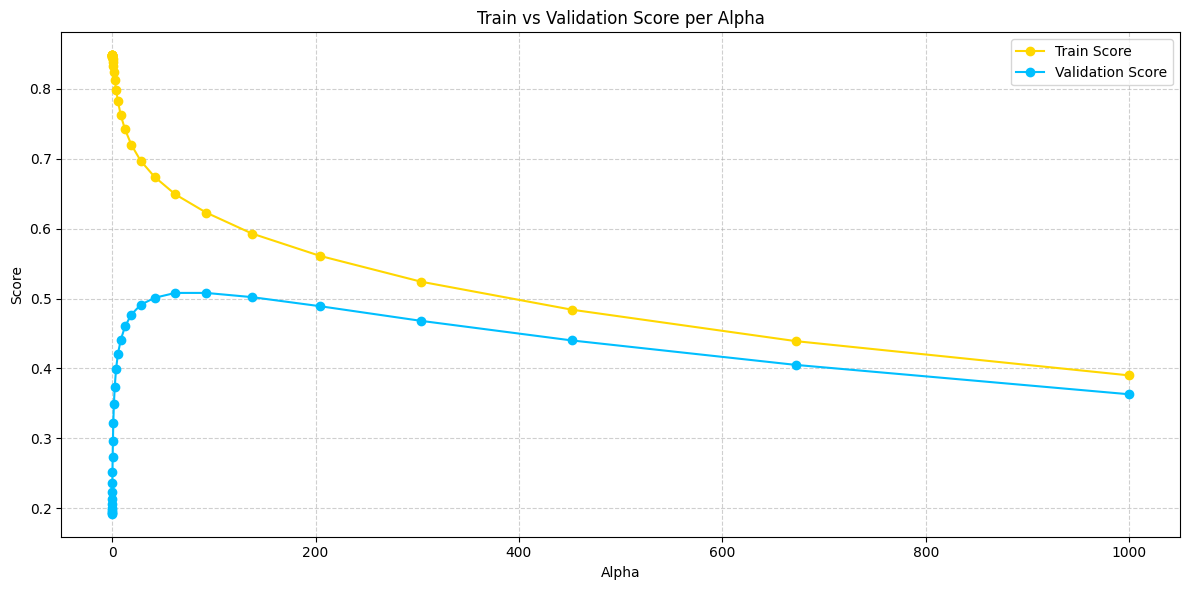

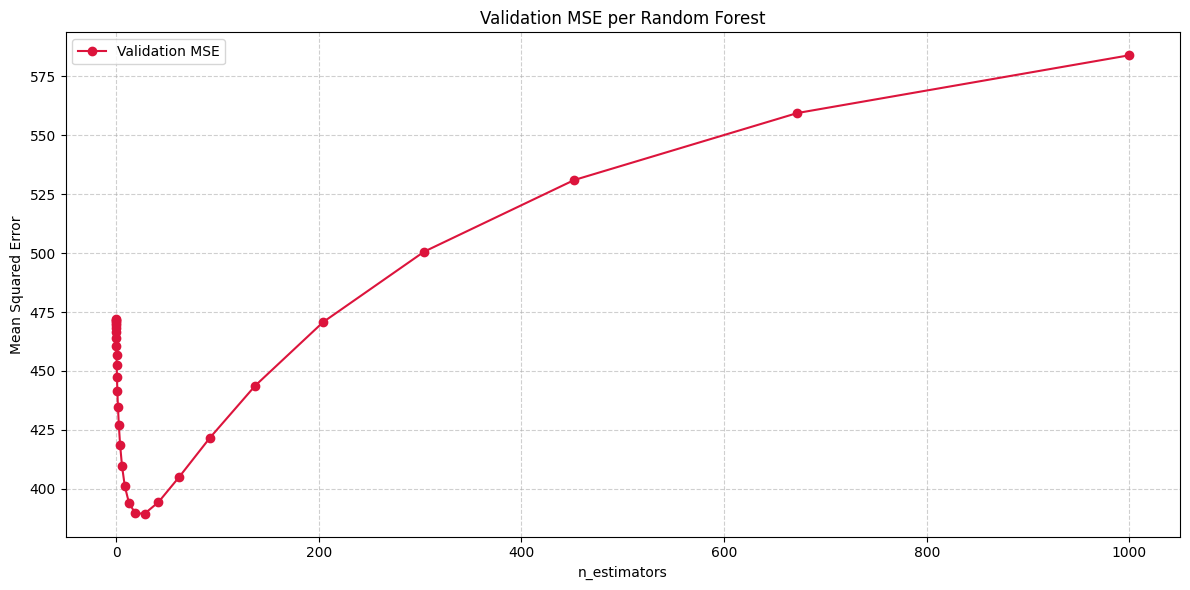

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Dades
alphas = df_results_ridge['alpha']
train_scores = df_results_ridge['train_score_mean']
val_scores = df_results_ridge['val_score_mean']
val_mse = df_results_ridge['val_mse_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(alphas, train_scores, marker='o', color='gold', label='Train Score')
plt.plot(alphas, val_scores, marker='o', color='deepskyblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Train vs Validation Score per Alpha')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.ylim(0.05, 0.6)

# Gràfic 2: MSE en test
plt.figure(figsize=(12, 6))
plt.plot(alphas, val_mse, marker='o', color='crimson', label='Validation MSE')
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE per Random Forest')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Random Forest

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

talls = np.concatenate([np.arange(1, 31, 5),np.arange(31, 151, 20),np.arange(151, 401, 50)])
results_rf = []
c = 0

# Prova diferents valors de n_estimators (nombre d’arbres)
for n_estimators in talls:
    m = []
    n = []
    c += 1
    test_mse = []
    
    for r in range(1, 41):
        print(f"{round((c-1+(r-1)/40)*100/len(talls), 3)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        rf_reg = RandomForestRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
        rf_reg.fit(train_X, train_y)
        m.append(rf_reg.score(train_X, train_y))
        n.append(rf_reg.score(test_X, test_y))
        y_pred = rf_reg.predict(test_X)
        y_pred_original = np.expm1(y_pred)  # exp(x) - 1
        y_original = np.expm1(test_y)
        test_mse.append(mean_squared_error(y_original, y_pred_original))
    results_rf.append([n_estimators, round(np.mean(m), 3), round(np.mean(n), 3), round(np.mean(test_mse), 3)])

df_results_rf = pd.DataFrame(results_rf, columns=['n_estimators', 'train_score_mean', 'val_score_mean', 'val_mse_mean'])
print(df_results_rf.loc[df_results_rf['val_score_mean'].idxmax()])
print(df_results_rf.loc[df_results_rf['val_mse_mean'].idxmin()])

# Desa i recarrega si cal
df_results_rf.to_pickle(path="data/rf_TB_log.pkl")

n_estimators        251.000
train_score_mean      0.930
val_score_mean        0.515
val_mse_mean        389.739
Name: 14, dtype: float64
n_estimators        201.000
train_score_mean      0.930
val_score_mean        0.514
val_mse_mean        389.536
Name: 13, dtype: float64


In [69]:
df_results_rf = pd.read_pickle("data/rf_TB_log.pkl")

best_n = int(df_results_rf.loc[df_results_rf['val_score_mean'].idxmax(), 'n_estimators'])
best_n = 51 #L'escollim en base al gràfic
rf_reg = RandomForestRegressor(n_estimators=best_n, random_state=42, n_jobs=-1)
rf_reg.fit(x, y)
y_pred = rf_reg.predict(x)
y_pred_original = np.expm1(y_pred)  # exp(x) - 1
y_original = np.expm1(y)
mse_real = mean_squared_error(y_original, y_pred_original)
definitiu = pd.DataFrame([[rf_reg.score(x, y), mse_real]], columns=['R² (score)', 'MSE'])
print(definitiu)
best_row = df_results_rf[df_results_rf['n_estimators'] == best_n]
print(best_row)
definitiu.to_pickle(path="data/rf_TB_log_opt.pkl")
best_row.to_pickle(path="data/rf_TB_log_rem_opt.pkl")


   R² (score)        MSE
0    0.927048  96.777733
   n_estimators  train_score_mean  val_score_mean  val_mse_mean
7            51             0.925           0.506       394.472


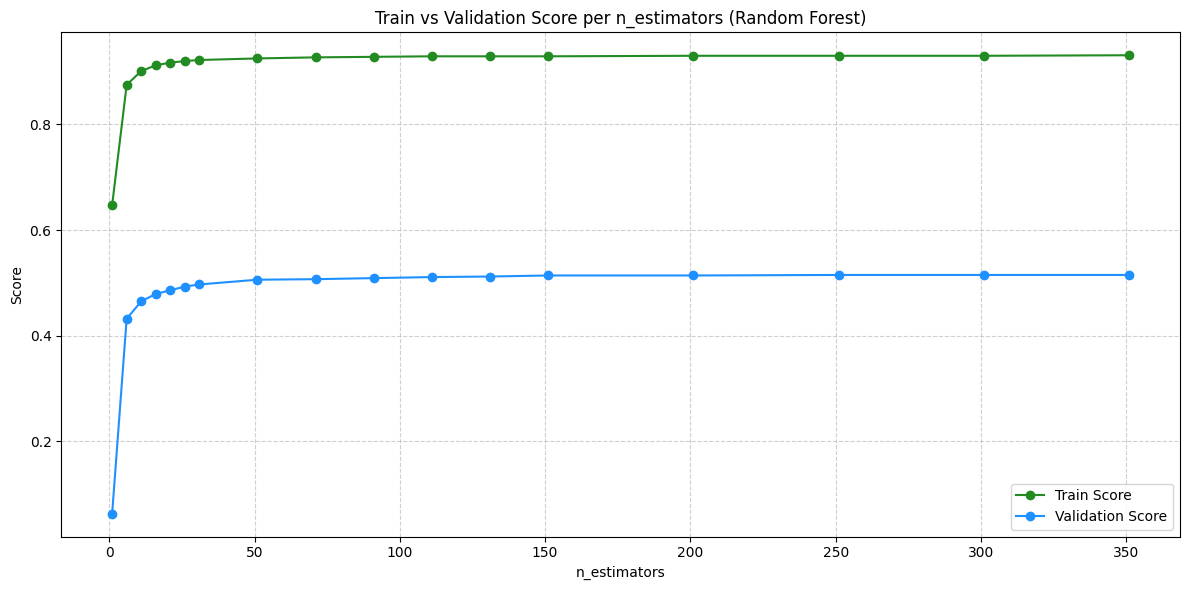

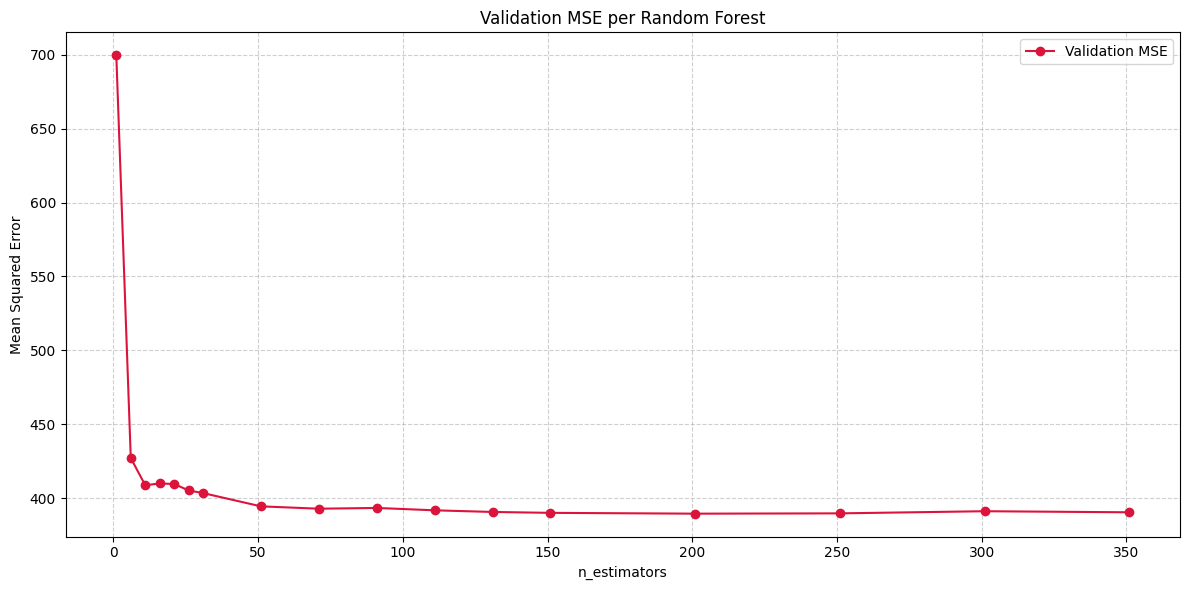

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Dades del Random Forest
n_estimators = df_results_rf['n_estimators']
train_scores_rf = df_results_rf['train_score_mean']
val_scores_rf = df_results_rf['val_score_mean']
val_mse = df_results_rf['val_mse_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores_rf, marker='o', color='forestgreen', label='Train Score')
plt.plot(n_estimators, val_scores_rf, marker='o', color='dodgerblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('Train vs Validation Score per n_estimators (Random Forest)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.ylim(-1, 1) 

# Gràfic 2: MSE en test
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, val_mse, marker='o', color='crimson', label='Validation MSE')
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE per Random Forest')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


XGBoost

In [71]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

talls = np.arange(1, 60, 2)
results = []
c = 0

for i in talls:
    train_scores = []
    test_scores = []
    test_mse = []
    
    for r in range(1, 41):
        print(f"{round(100 * (c+(r-1)/40)/len(talls), 3)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        model = XGBRegressor(n_estimators=int(i), max_depth=6, learning_rate=0.1, verbosity=0)
        model.fit(train_X, train_y)
        train_scores.append(model.score(train_X, train_y))
        test_scores.append(model.score(test_X, test_y))
        y_pred = model.predict(test_X)
        y_pred_original = np.expm1(y_pred)  # exp(x) - 1
        y_original = np.expm1(test_y)
        test_mse.append(mean_squared_error(y_original, y_pred_original))
    results.append([int(i), round(np.mean(train_scores), 3), round(np.mean(test_scores), 3), round(np.mean(test_mse), 3)])
    c += 1

df_results_xgb = pd.DataFrame(results, columns=['n_estimators', 'train_score_mean', 'val_score_mean', 'val_mse_mean'])
print(df_results_xgb.loc[df_results_xgb['val_score_mean'].idxmax()])
print(df_results_xgb.loc[df_results_xgb['val_mse_mean'].idxmin()])
df_results_xgb.to_pickle("data/xgb_TB_log.pkl")


n_estimators         31.000
train_score_mean      0.949
val_score_mean        0.476
val_mse_mean        391.600
Name: 15, dtype: float64
n_estimators         33.000
train_score_mean      0.955
val_score_mean        0.476
val_mse_mean        391.039
Name: 16, dtype: float64


In [72]:
df_results_xgb = pd.read_pickle("data/xgb_TB_log.pkl")

best_n = int(df_results_xgb.loc[df_results_xgb['val_mse_mean'].idxmin(), 'n_estimators'])
model = XGBRegressor(n_estimators=best_n)
model.fit(x, y)
y_pred = model.predict(x)
y_pred_original = np.expm1(y_pred)  # exp(x) - 1
y_original = np.expm1(y)
mse_real = mean_squared_error(y_original, y_pred_original)
definitiu = pd.DataFrame([[model.score(x, y), mse_real]], columns=['R² (score)', 'MSE'])
print(definitiu)
best_row = df_results_xgb[df_results_xgb['n_estimators'] == best_n]
print(best_row)
definitiu.to_pickle(path="data/xgb_TB_log_opt.pkl")
best_row.to_pickle(path="data/xgb_TB_log_rem_opt.pkl")

   R² (score)       MSE
0    0.995402  8.442801
    n_estimators  train_score_mean  val_score_mean  val_mse_mean
16            33             0.955           0.476       391.039


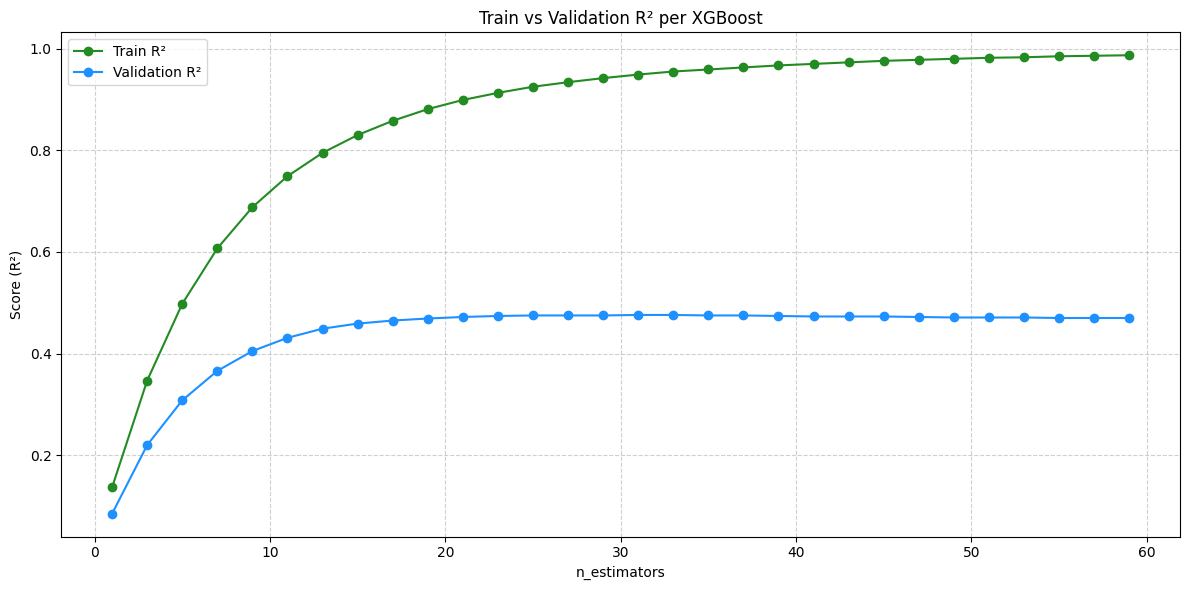

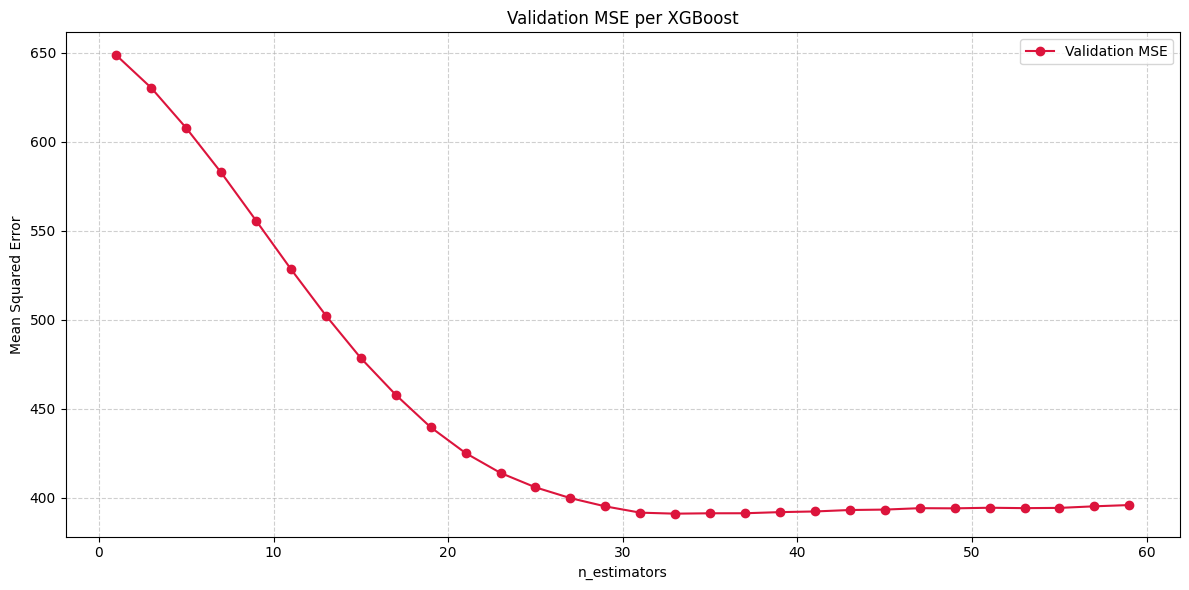

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Dades del XGBoost
n_estimators = df_results_xgb['n_estimators']
train_scores = df_results_xgb['train_score_mean']
val_scores = df_results_xgb['val_score_mean']
val_mse = df_results_xgb['val_mse_mean']

# Gràfic 1: R² Train vs Validation
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores, marker='o', color='forestgreen', label='Train R²')
plt.plot(n_estimators, val_scores, marker='o', color='dodgerblue', label='Validation R²')
plt.xlabel('n_estimators')
plt.ylabel('Score (R²)')
plt.title('Train vs Validation R² per XGBoost')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.ylim(-0.2, 1.2)
plt.show()

# Gràfic 2: MSE en test
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, val_mse, marker='o', color='crimson', label='Validation MSE')
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE per XGBoost')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

SVR

In [74]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

results = []
c = 0
for i in np.logspace(-6, 0, num=30):
    train_scores = []
    val_scores = []
    test_mse = []
    
    for r in range(1, 41):  # pots fer més o menys iteracions
        print(f"{round((c+(r-1)/40)/30*100, 2)}%", end='\r', flush=True)
        train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=r)
        
        svr_model = SVR(C=i, kernel='linear', epsilon=0.1, max_iter=1000)
        svr_model.fit(train_X, train_y)
        
        train_scores.append(svr_model.score(train_X, train_y))
        val_scores.append(svr_model.score(test_X, test_y))
        y_pred = svr_model.predict(test_X)
        y_pred_original = np.expm1(y_pred)  # exp(x) - 1
        y_original = np.expm1(test_y)
        test_mse.append(mean_squared_error(y_original, y_pred_original))
    c += 1
    results.append([round(i, 6), np.mean(train_scores), np.mean(val_scores), round(np.mean(test_mse), 3)])

# Guardem els resultats
df_results_svr = pd.DataFrame(results, columns=['C', 'train_score_mean', 'val_score_mean', 'val_mse_mean'])
print(df_results_svr.loc[df_results_svr['val_score_mean'].idxmax()])
print(df_results_svr.loc[df_results_svr['val_mse_mean'].idxmin()])
df_results_svr.to_pickle("data/svr_TB_log.pkl")


C                     0.013738
train_score_mean      0.606923
val_score_mean        0.485782
val_mse_mean        417.309000
Name: 20, dtype: float64
C                     0.022122
train_score_mean      0.635209
val_score_mean        0.479170
val_mse_mean        406.457000
Name: 21, dtype: float64


In [83]:
df_results_svr = pd.read_pickle("data/svr_TB_log.pkl")

best_C = df_results_svr.loc[df_results_svr['val_mse_mean'].idxmin(), 'C']
final_svr = SVR(C=best_C, kernel='linear', epsilon=0.1, max_iter=1000)
final_svr.fit(x, y)
y_pred = final_svr.predict(x)
y_pred_original = np.expm1(y_pred)  # exp(x) - 1
y_original = np.expm1(y)
mse_real = mean_squared_error(y_original, y_pred_original)
definitiu = pd.DataFrame([[final_svr.score(x, y), mse_real]], columns=['R² (score)', 'MSE'])
print(definitiu)
best_row = df_results_svr[df_results_svr['C'] == best_C]
print(best_row)
definitiu.to_pickle(path="data/svr_TB_log_opt.pkl")
best_row.to_pickle(path="data/svr_TB_log_rem_opt.pkl")


   R² (score)         MSE
0    0.628392  318.480767
           C  train_score_mean  val_score_mean  val_mse_mean
21  0.022122          0.635209         0.47917       406.457


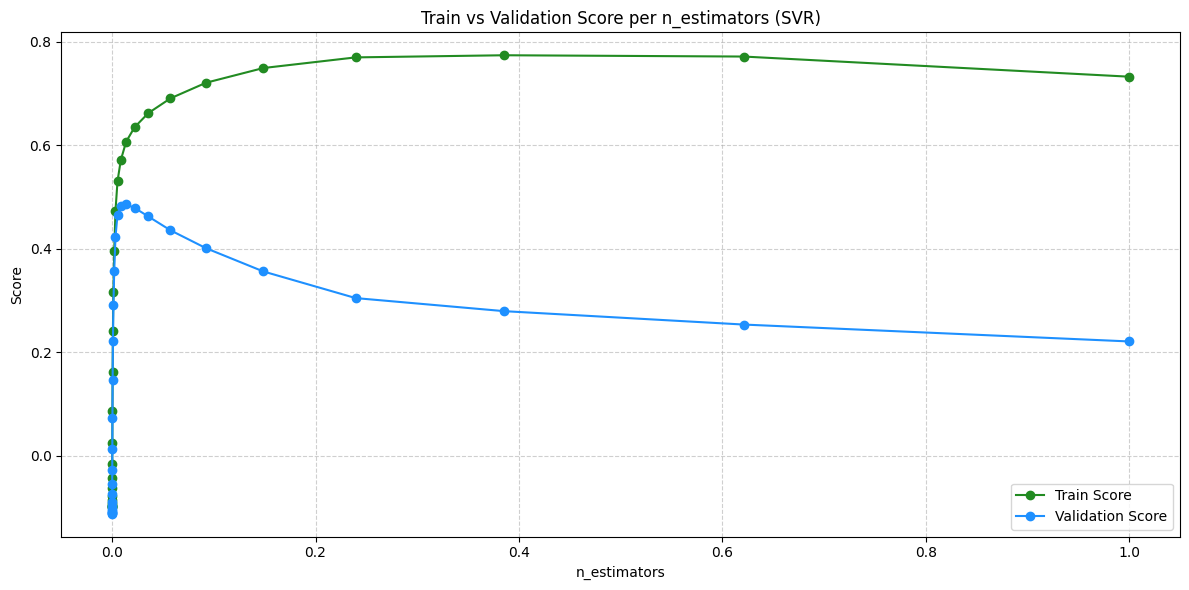

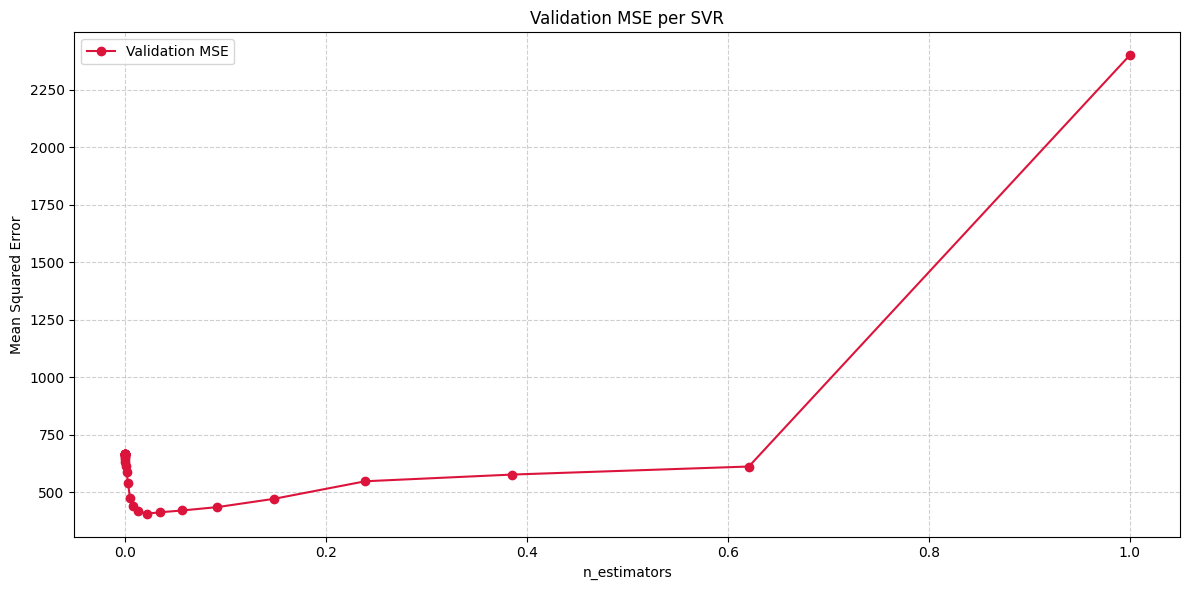

In [76]:
import matplotlib.pyplot as plt
import numpy as np

n_estimators = df_results_svr['C']
train_scores_rf = df_results_svr['train_score_mean']
val_scores_rf = df_results_svr['val_score_mean']
val_mse = df_results_svr['val_mse_mean']

# Crear el gràfic de línies
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, train_scores_rf, marker='o', color='forestgreen', label='Train Score')
plt.plot(n_estimators, val_scores_rf, marker='o', color='dodgerblue', label='Validation Score')

# Etiquetes i títol
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('Train vs Validation Score per n_estimators (SVR)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.ylim(-0.3, 0.5)

# Gràfic 2: MSE en test
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, val_mse, marker='o', color='crimson', label='Validation MSE')
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE per SVR')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
